In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood
from sklearn.model_selection import train_test_split

In [4]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset

In [5]:
batch_size = 32
aug = 10
data_path = '../data/'
device = 'cuda'

In [6]:
lrg_data_set   = LRG(112, rd_sz=128, use_kittler=True, n_aug=aug, blur=False, 
                     catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                     file_dir=data_path + 'lrg')

../data/lrg:	1442/1442


In [7]:
x, y = lrg_data_set.get_data()
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [8]:
train_dataset = BasicDataset(X_train, y_train, n_aug=5, sz=112) #
test_dataset  = BasicDataset(X_test,  y_test,  n_aug=5,  sz=112)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

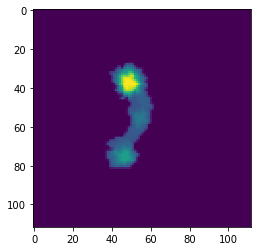

In [9]:
sample = iter(test_dataloader).next()
plt.imshow(sample[0].numpy()[10][0])
plt.show()

In [19]:
# model = DeepClassifier(k=cfgs['vgg11'], batchnorm=False, use_stn=True)
# model(sample[0])

In [11]:
class DeepClassifier(nn.Module):
    ''' Somewhat inspired in VGG
        Adds option for STN network
    '''
    def __init__(self, k=None, num_classes=6, lt_dim=8, batchnorm=True, use_stn=False, in_channels=1, non_linearity=nn.ReLU,
                 Conv2d=nn.Conv2d, MaxPool2d=nn.MaxPool2d, BatchNorm2d=nn.BatchNorm2d):
        super(DeepClassifier, self).__init__()
        
        self.use_stn = use_stn
        self.non_linearity = non_linearity
        self.Conv2d = Conv2d
        self.MaxPool2d = MaxPool2d
        self.BatchNorm2d = BatchNorm2d
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, lt_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(lt_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((3, 3))
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        if k == None:
            k = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

        layers = self.__make_layers(k, batchnorm)
        self.features = nn.Sequential(*layers)
        self._initialize_weights()

    def __make_layers(self, k, batch_norm, in_channels=1):
        layers = []
        for v in k:
            if v == 'M' :
                layers += [self.MaxPool2d(kernel_size=2, stride=2)]
            else :
                conv2d = self.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, self.BatchNorm2d(v), self.non_linearity(inplace=True)]
                else:
                    layers += [conv2d, self.non_linearity(inplace=True)]
                in_channels = v
#         for l in layers: print(l)
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        
        if self.use_stn:
            x = self.stn(x)
        
        y = self.features(x)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y

'''Common configs for VGG like networks'''
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M'],
}

In [12]:
def train(model, dataloader, optimizer, epoch, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
        
        s = 'Train Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\tTrain Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
        sys.stdout.write('{}\r'.format(s))
        sys.stdout.flush()

        del loss, _, preds, outputs
    del running_corrects
    return running_loss, running_acc, s

In [13]:
def test(model, dataloader, optimizer, epoch, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
#         s = 'Test Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\trPreds: {:.4f}'
#         s = s.format(epoch,
#                 100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
#         sys.stdout.write('{}\r'.format(s))
#         sys.stdout.flush()

        del loss, _, preds, outputs
    del running_corrects
    return running_loss, running_acc#, s

In [14]:
epochs = 100
lr = 0.0001

In [33]:
model = DeepClassifier(k=cfgs['vgg11'], batchnorm=False, use_stn=True).to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))

Train Epoch:   1 ( 99%)	Loss:	1.6731	rLoss: 15498.29	Train Acc: 0.2914 Test Acc: 0.2818	Time: 15.4923
Train Epoch:   2 ( 99%)	Loss:	1.6919	rLoss: 15099.21	Train Acc: 0.3086 Test Acc: 0.4123	Time: 14.9939
Train Epoch:   3 ( 99%)	Loss:	1.4645	rLoss: 14722.11	Train Acc: 0.3947 Test Acc: 0.3826	Time: 14.9387
Train Epoch:   4 ( 99%)	Loss:	1.1907	rLoss: 13937.33	Train Acc: 0.4399 Test Acc: 0.4309	Time: 14.8207
Train Epoch:   5 ( 99%)	Loss:	1.1610	rLoss: 13117.36	Train Acc: 0.4544 Test Acc: 0.4343	Time: 14.8124
Train Epoch:   6 ( 99%)	Loss:	1.0493	rLoss: 12923.18	Train Acc: 0.4572 Test Acc: 0.4424	Time: 14.8105
Train Epoch:   7 ( 99%)	Loss:	1.2911	rLoss: 12685.62	Train Acc: 0.4569 Test Acc: 0.4301	Time: 14.8107
Train Epoch:   8 ( 99%)	Loss:	1.0287	rLoss: 11976.85	Train Acc: 0.4720 Test Acc: 0.4767	Time: 14.8035
Train Epoch:   9 ( 99%)	Loss:	1.0315	rLoss: 11136.39	Train Acc: 0.4905 Test Acc: 0.4992	Time: 14.8171
Train Epoch:  10 ( 99%)	Loss:	1.2063	rLoss: 10844.38	Train Acc: 0.4913 Test Acc: 0

Train Epoch:  82 ( 99%)	Loss:	0.6851	rLoss: 5866.20	Train Acc: 0.7754 Test Acc: 0.6797	Time: 14.8608
Train Epoch:  83 ( 99%)	Loss:	0.5526	rLoss: 5866.01	Train Acc: 0.7736 Test Acc: 0.7093	Time: 14.8014
Train Epoch:  84 ( 99%)	Loss:	0.7185	rLoss: 6034.68	Train Acc: 0.7750 Test Acc: 0.6407	Time: 14.8314
Train Epoch:  85 ( 99%)	Loss:	0.6625	rLoss: 5697.39	Train Acc: 0.7805 Test Acc: 0.6525	Time: 14.8539
Train Epoch:  86 ( 99%)	Loss:	0.6125	rLoss: 5698.62	Train Acc: 0.7812 Test Acc: 0.6894	Time: 14.8053
Train Epoch:  87 ( 99%)	Loss:	0.7254	rLoss: 5652.44	Train Acc: 0.7848 Test Acc: 0.6822	Time: 14.8949
Train Epoch:  88 ( 99%)	Loss:	0.6799	rLoss: 5624.75	Train Acc: 0.7828 Test Acc: 0.6504	Time: 14.8807
Train Epoch:  89 ( 99%)	Loss:	0.4850	rLoss: 5603.39	Train Acc: 0.7890 Test Acc: 0.7233	Time: 14.9000
Train Epoch:  90 ( 99%)	Loss:	0.3229	rLoss: 5469.29	Train Acc: 0.7884 Test Acc: 0.7314	Time: 14.8745
Train Epoch:  91 ( 99%)	Loss:	0.6547	rLoss: 5295.84	Train Acc: 0.7926 Test Acc: 0.6966	Time

In [16]:
# model = DeepClassifier(k=cfgs['vgg11'], batchnorm=True).to(device)
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(1, epochs+1):
#     start = time.time()
#     train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
#     test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
#     t = time.time() - start
#     print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))

In [20]:
from RotEqNet.layers_2D import *

In [21]:
class RotEqDeepClassifier(nn.Module):
    ''' Somewhat inspired in VGG
        Adds option for STN network
    '''
    def __init__(self, k=None, num_classes=6, lt_dim=8, batchnorm=True, in_channels=1, non_linearity=nn.ReLU):
        super(RotEqDeepClassifier, self).__init__()
        
        self.non_linearity = non_linearity
                
        if k == None:
            k = [32, 'M', 64, 'M', 128, 128, 'M', 'R', 256, 256, 'M']

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(k[-2] * 7 * 7, lt_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(lt_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        layers = self.__make_layers(k, batchnorm)
        self.features = nn.Sequential(*layers)
        self._initialize_weights()

    def __make_layers(self, k, batch_norm, in_channels=1, mode=1):
        layers = []
        use_rot = True
        for v in k:
#             print('=============================',k,'====================')
            if v == 'R':
                use_rot = False
                conv2d = RotConv(in_channels, in_channels, kernel_size=[3,3], padding=1, mode=mode, n_angles = 17)
                layers += [conv2d, Vector2Magnitude()]
            elif v == 'M' :
                if use_rot:
                    layers += [VectorMaxPool(kernel_size=2, stride=2)]
                else:
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                if use_rot:
                    conv2d = RotConv(in_channels, v, kernel_size=[3,3], padding=1, mode=mode, n_angles = 17)
                else:
                    conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    if use_rot:
                        layers += [conv2d, VectorBatchNorm(v)]
                    else:
                        layers += [conv2d, nn.BatchNorm2d(v), self.non_linearity(inplace=True)]
                else:
                    if use_rot:
                        layers += [conv2d]
                    else:
                        layers += [conv2d, self.non_linearity(inplace=True)]
                in_channels = v
                mode = 2
#         for l in layers : print(l)
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        
        y = self.features(x)
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y

In [17]:
# model.features[:15]

In [22]:
# model = RotEqDeepClassifier(batchnorm=False).to(device)
# o = model(sample[0].to(device))
# o

In [23]:
model = RotEqDeepClassifier(batchnorm=False).to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
criterion = nn.CrossEntropyLoss()

# model.half()  # convert to half precision
# for layer in model.modules():
#     if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, VectorBatchNorm):
#         layer.float()

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))
    del train_l, train_c, test_l,  test_c

Train Epoch:   1 ( 99%)	Loss:	1.4438	rLoss: 7990.98	Train Acc: 0.2890 Test Acc: 0.2903	Time: 112.3038
Train Epoch:   2 ( 99%)	Loss:	1.5547	rLoss: 7554.60	Train Acc: 0.2832 Test Acc: 0.2903	Time: 112.1237
Train Epoch:   3 ( 99%)	Loss:	1.6038	rLoss: 7491.57	Train Acc: 0.2995 Test Acc: 0.2669	Time: 112.3508
Train Epoch:   4 ( 99%)	Loss:	1.4653	rLoss: 7485.11	Train Acc: 0.2989 Test Acc: 0.2903	Time: 112.5409
Train Epoch:   5 ( 99%)	Loss:	1.5413	rLoss: 7434.03	Train Acc: 0.2853 Test Acc: 0.2903	Time: 112.4355
Train Epoch:   6 ( 99%)	Loss:	1.4584	rLoss: 7429.89	Train Acc: 0.2905 Test Acc: 0.2903	Time: 112.4700
Train Epoch:   7 ( 99%)	Loss:	1.7141	rLoss: 7412.95	Train Acc: 0.2951 Test Acc: 0.2903	Time: 112.5302
Train Epoch:   8 ( 99%)	Loss:	1.3988	rLoss: 7413.53	Train Acc: 0.2825 Test Acc: 0.2903	Time: 112.4742
Train Epoch:   9 ( 99%)	Loss:	1.6637	rLoss: 7411.23	Train Acc: 0.2940 Test Acc: 0.2669	Time: 112.4214
Train Epoch:  10 ( 99%)	Loss:	1.6048	rLoss: 7411.82	Train Acc: 0.3005 Test Acc: 0.

KeyboardInterrupt: 

In [25]:
del model